<a href="https://colab.research.google.com/github/meDoLIF/sf_data_science/blob/main/Trainig/ML-7.%20%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F%20%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8/Miniproject_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score #Кросс валидация

# Импорт оптимизаторов параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

%matplotlib inline
plt.style.use('seaborn')

q:\DS\python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

В качестве метрики будем использовать F1-score.

In [ ]:
df = pd.read_csv('data/_train_sem09 (1).csv')

In [ ]:
#проверим что датасет сформировался корректно
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; (Целевой признак)
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

In [ ]:
# Разобъём наши данные на Зависимые (y) и Независимые (X)

X = df.drop(['Activity'], axis = 1)
y = df['Activity']

#Проверим по размерам выборок что разделение прошло успешно

print('Размер df', df.shape)
print('Размер X', X.shape)
print('Размер y', y.shape)

Размер df (3751, 1777)
Размер X (3751, 1776)
Размер y (3751,)


In [ ]:
#Проверим, насколько равномерно разделены целевые данные, чтобы определить необходимость в стратификации при разделении на тренировочную и тестовую выборки

y.value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

Данные разделены примерно поровну, поэтому делать стратификацию не обязательно

In [ ]:
#Разделим данные на тренировочные и тестовые

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

# Создание BaseLine моделей

Высчитаем F1-score для моделей Логистической регрессии и Случайном лесе на параметрах по умолчанию

In [ ]:
#Baseline для логистической регрессии
logReg_base = linear_model.LogisticRegression(random_state=42, max_iter= 50)

logReg_base.fit(X_train, y_train)

y_pred_logReg_base = logReg_base.predict(X_test)

f1_logReg_base = metrics.f1_score(y_test, y_pred_logReg_base)

q:\DS\python\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))

F1-score на Baseline для логистической регресии равен 0.79


In [ ]:
#Baseline для случайного леса

rf_base = ensemble.RandomForestClassifier(random_state= 42)

rf_base.fit(X_train, y_train)

y_pred_rf_base = rf_base.predict(X_test)

f1_rf_base = metrics.f1_score(y_test, y_pred_rf_base)


In [ ]:
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))

F1-score на Baseline для случайного леса равен 0.83


# Построение модели с помощью GridSearchCV

## На основе логистической регресии

In [ ]:
param_grid = [
    {'penalty' : ['l2', 'none'], # тип регуляризации
    'solver' : ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
    'C' : [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

gs_logReg = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state= 42, max_iter = 50),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring='f1'
)

%time gs_logReg.fit(X_train, y_train)

y_pred_gs_logReg = gs_logReg.predict(X_test)

f1_gs_logReg = metrics.f1_score(y_test, y_pred_gs_logReg)

CPU times: total: 12.1 s
Wall time: 6min 27s


In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(gs_logReg.best_params_))

Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


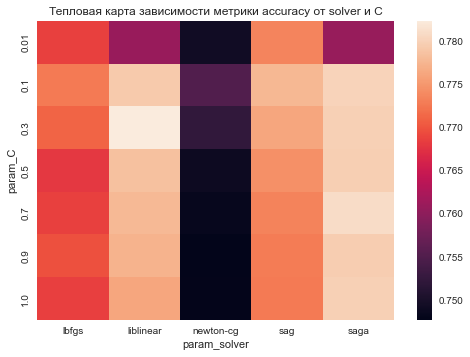

In [ ]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(gs_logReg.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Из тепловой карты видно, что нет смысла пробовать создать модель с большей силой регуляризации

In [ ]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на GridSearchCV для логистической регресии равен {:.2f}'.format(f1_gs_logReg))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на GridSearchCV для логистической регресии равен 0.79


К сожалению получить показатель лучше чем BaseLine не удалось

## На основе Случайного Леса

In [ ]:
param_grid = {
    'min_samples_leaf' : list(np.linspace(5, 25, 10, dtype=int)),
    'max_depth' : list(np.linspace(1, 30, 6, dtype = int)),
    'n_estimators' : list(np.linspace(80,200, 30, dtype = int))
}

gs_rf = GridSearchCV(
    estimator= ensemble.RandomForestClassifier(random_state= 42),
    param_grid= param_grid,
    cv = 5,
    n_jobs= -1,
    scoring = 'f1'
)

%time gs_rf.fit(X_train, y_train)

f1_gs_rf = gs_rf.score(X_test, y_test)

CPU times: total: 34.3 s
Wall time: 21min 47s


In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(gs_rf.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 100}


In [ ]:
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на GridResearchCV для случайного леса равен {:.2f}'.format(f1_gs_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на GridResearchCV для случайного леса равен 0.83


К сожалению получить показатель лучше чем BaseLine не удалось

# RandomizedSearchCV

## Логистическая регрессия

In [ ]:
param_distribution = [
    {'penalty' : ['l2', 'none'], # тип регуляризации
    'solver' : ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
    'C' : [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

rs_logReg = RandomizedSearchCV(
    estimator= linear_model.LogisticRegression(random_state=42, max_iter=50),
    param_distributions=param_distribution,
    cv = 5,
    n_iter= 50,
    n_jobs= -1,
    scoring='f1'
)

%time rs_logReg.fit(X_train, y_train)

f1_rs_logReg = rs_logReg.score(X_test, y_test)

CPU times: total: 10.7 s
Wall time: 5min 41s


In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(rs_logReg.best_params_))

Наилучшие значения гиперпараметров: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}


In [ ]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на RandomizedSrearchCV для логистической регресии равен {:.2f}'.format(f1_rs_logReg))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на RandomizedSrearchCV для логистической регресии равен 0.79


## Случайный лес

In [ ]:
param_distribution = {
    'min_samples_leaf' : list(np.linspace(5, 25, 10, dtype=int)),
    'max_depth' : list(np.linspace(1, 30, 6, dtype = int)),
    'n_estimators' : list(np.linspace(80,200, 30, dtype = int))
}

rs_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distribution,
    cv = 5,
    n_iter = 50,
    n_jobs= -1,
    scoring= 'f1'
)

rs_rf.fit(X_train, y_train)

f1_rs_rf = rs_rf.score(X_test, y_test)

In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(rs_rf.best_params_))

Наилучшие значения гиперпараметров: {'n_estimators': 125, 'min_samples_leaf': 5, 'max_depth': 24}


In [ ]:
#Сравним результат с BaseLine
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на RandomizedSrearchCV для случайного леса равен {:.2f}'.format(f1_rs_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на RandomizedSrearchCV для случайного леса равен 0.83


# HyperOpt

## Логистическая регрессия

In [ ]:
#зададим пространство поиска гиперпараметров
"""space = [
    {'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации
    'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации
    'C' : hp.loguniform('C', low = -2*np.log(10), high = 1)}, # уровень силы регурялизации
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    
    {'penalty': hp.choice(label='penalty', options= ['l1', 'l2']) ,
    'solver': hp.choice(label = 'solver', options= ['liblinear', 'saga']),
    'C': hp.loguniform('C', low = -2*np.log(10), high = 1)}
]"""

"{'penalty': hp.choice(label='penalty', options= ['l1', 'l2']) ,\n    'solver': hp.choice(label = 'solver', options= ['liblinear', 'saga']),\n    'C': hp.loguniform('C', low = -2*np.log(10), high = 1)}"

In [ ]:
space ={
    'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации
    'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации
    'C' : hp.loguniform(label='C', low=-2*np.log(10), high=2*np.log(10))}, # уровень силы регурялизации

In [ ]:
random_state = 42

def hyperopt_lr(params, cv = 5, X = X_train, y = y_train, random_state = random_state):
    params = {
        'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации
        'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации
        'C' : hp.loguniform(label='C', low=-2*np.log(10), high=2*np.log(10))
    }
    
    model = linear_model.LogisticRegression(**params, random_state = random_state)
    
    model.fit(X, y)
    
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score

In [ ]:
%time

trials = Trials()

best = fmin(hyperopt_lr, #наша функция
    space = space, #Пространство параметров
    max_evals= 50, #Количество итераций
    trials = trials,# логирование результатов
    rstate = np.random.default_rng(random_state)
)

print('Наилучшие параметры {}'.format(best))

TPE is being used as the default algorithm.


CPU times: total: 0 ns
Wall time: 0 ns
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got 0 switch
1   hyperopt_param
2     Literal{solver}
3     randint
4       Literal{3}
5   Literal{newton-cg}
6   Literal{lbfgs}
7   Literal{sag}.



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got 0 switch
1   hyperopt_param
2     Literal{solver}
3     randint
4       Literal{3}
5   Literal{newton-cg}
6   Literal{lbfgs}
7   Literal{sag}.

## Случайный лес

In [ ]:
space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
       'max_depth' : hp.quniform('max_depth', 1, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 25, 1)
      }

In [ ]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
    }
    # используем эту комбинацию для построения модели   
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score    
    

In [ ]:
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [02:08<00:00,  2.57s/trial, best loss: -0.8051423755259064]
Наилучшие значения гиперпараметров {'max_depth': 28.0, 'min_samples_leaf': 5.0, 'n_estimators': 101.0}


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_pred_ho_rf = model.predict(X_test)

f1_ho_rf = metrics.f1_score(y_test, y_pred_ho_rf)

In [ ]:
#Сравним результат с BaseLine
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на HyperOpt для случайного леса равен {:.2f}'.format(f1_ho_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на HyperOpt для случайного леса равен 0.84


# Optuna

## Логистическая регрессия

In [ ]:
def optuna_lr(trial):
    penalty = trial.suggest_categorical(name='penalty', choices= ['l2', 'none']) # тип регуляризации
    solver = trial.suggest_categorical(name = 'solver', choices= ['newton-cg', 'lbfgs', 'sag']) # алгоритм оптимизации
    C = trial.suggest_float(name='C', low=0.01, high=1, step = 0.1) # уровень силы регурялизации
    
    model = linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C = C,
        random_state=random_state
    )
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [ ]:
%%time

study = optuna.create_study(study_name='LogisticRegression', direction='maximize')

study.optimize(optuna_lr, n_trials= 50)

[I 2022-10-06 22:12:04,945] A new study created in memory with name: LogisticRegression
q:\DS\python\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.01, 1] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.01, 0.91].
  warnings.warn(
q:\DS\python\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2022-10-06 22:12:09,579] Trial 0 finished with value: 0.7716759100571287 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.81}. Best is trial 0 with value: 0.7716759100571

CPU times: total: 10min 46s
Wall time: 7min 41s


In [ ]:
model = linear_model.LogisticRegression(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)

y_pred_optuna_lr = model.predict(X_test)

f1_optuna_lr = metrics.f1_score(y_test, y_pred_optuna_lr)

In [ ]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на Optuna для логистической регресии равен {:.2f}'.format(f1_optuna_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на Optuna для логистической регресии равен 0.79


## Случайный лес

In [ ]:
def optuna_rf(trial):
    n_estimators =  trial.suggest_int('n_estimators', 80, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 25, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state=random_state 
    )
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1', n_jobs= -1).mean()
    
    return score

In [ ]:
%%time

study = optuna.create_study(study_name='RandomForestClassification', direction='maximize')

study.optimize(optuna_rf, n_trials= 50)

[I 2022-10-06 22:03:13,352] A new study created in memory with name: RandomForestClassification
[I 2022-10-06 22:03:18,077] Trial 0 finished with value: 0.7832854118874215 and parameters: {'n_estimators': 117, 'max_depth': 15, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.7832854118874215.
[I 2022-10-06 22:03:21,972] Trial 1 finished with value: 0.7653299426870736 and parameters: {'n_estimators': 194, 'max_depth': 8, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.7832854118874215.
[I 2022-10-06 22:03:26,264] Trial 2 finished with value: 0.7784149554705364 and parameters: {'n_estimators': 181, 'max_depth': 10, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.7832854118874215.
[I 2022-10-06 22:03:28,208] Trial 3 finished with value: 0.7776012600834094 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.7832854118874215.
[I 2022-10-06 22:03:30,562] Trial 4 finished with value: 0.7664444353711548 and parameters

CPU times: total: 1min 12s
Wall time: 2min 51s


In [ ]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)

model.fit(X_train, y_train)

y_pred_optuna_rf = model.predict(X_test)

f1_optuna_rf = metrics.f1_score(y_test, y_pred_optuna_rf)

In [ ]:
#Сравним результат с BaseLine
print('F1-score на Baseline для Случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Baseline для Случайного леса равен 0.83
F1-score на Optuna для Случайного леса равен 0.82


# Итоги

## Линейная регрессия

In [ ]:
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на GridSearchCV для логистической регресии равен {:.2f}'.format(f1_gs_logReg))
print('F1-score на RandomizedSrearchCV для логистической регресии равен {:.2f}'.format(f1_rs_logReg))

print('F1-score на Optuna для логистической регресии равен {:.2f}'.format(f1_optuna_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на GridSearchCV для логистической регресии равен 0.79
F1-score на RandomizedSrearchCV для логистической регресии равен 0.79
F1-score на Optuna для логистической регресии равен 0.79


## Случайный лес

In [ ]:
print('F1-score на Baseline для Случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на GridResearchCV для случайного леса равен {:.2f}'.format(f1_gs_rf))
print('F1-score на RandomizedSrearchCV для случайного леса равен {:.2f}'.format(f1_rs_rf))
print('F1-score на HyperOpt для случайного леса равен {:.2f}'.format(f1_ho_rf))
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Baseline для Случайного леса равен 0.83
F1-score на GridResearchCV для случайного леса равен 0.83
F1-score на RandomizedSrearchCV для случайного леса равен 0.83
F1-score на HyperOpt для случайного леса равен 0.84
F1-score на Optuna для Случайного леса равен 0.82


Для логистической регрессии лучший результат f1_score = ... показал ..., а для Случайного леса лучший результат f1_score = 0.84 показал HyperOpt

P.S. В моём личном рейтинге страданий:

1 Место - HyperOpt, который никак не хотел вбирать в себя параметры логистической регресии\
2 Место - GridResearchCV, который на большой сетке параметров забрал у меня ноутбук на 2.5 часа и пришлось перенастраивать сетку\
3 Место - Optuna, которая, к сожалению, не преодолеть BaseLine, а я так в нее верил